In [3]:
from Functions.data_analysis import *
from Functions.edit_database import getTransactionData, getAccount
from Functions.variables import typeMapping
import numpy as np
from scipy.stats import linregress
import pandas as pd
import inspect
import sys

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [4]:
myAcc = getAccount("atlas")
myAcc.summary()

df = getTransactionData(myAcc)

       Username: atlas
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-08-27 06:59:40
   Date Updated: 2024-08-28 12:44:42
        Balance: 0


In [5]:
class enrichedData:
    def __init__(self, old_data: pd.DataFrame, data: pd.DataFrame, figsize: tuple[int, int] = (20, 6)) -> None:
        self.old_data = old_data
        self.data = data
        self.figsize = figsize
        
    def plotExpenses(self, RANGE1, RANGE2, displacement):
        _, ax = plt.subplots(figsize=self.figsize)

        last_data = self.data['Features', RANGE2].iloc[-1]

        curData = self.data[self.data['Features', RANGE2] == last_data]
        
        curData = curData.groupby(self.data['Features'][RANGE1]).sum()

        print(curData)

        curData['Expenses']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Expenses', color='green', alpha=0.6)

        plt.tight_layout()
        # plt.legend()
        plt.show()


In [6]:
def enrichData(df: pd.DataFrame) -> enrichedData:
    old_data = df.copy()
    def WoM(dt):
        """ Returns the week of the month for the specified date. """
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        
        return int(np.ceil(adjusted_dom / 7.0))

    df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
    df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
    
    
    expenses = pd.concat([
        df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
    ], axis=1)

    
    revenue = pd.concat([
        df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
    ], axis=1)

    expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
    revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


    expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
    revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

    expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
    revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


    features = pd.DataFrame(index=expenses.index.union(revenue.index))
    features[("Features", "DoW")] = features.index.day_of_week
    features[("Features", "DoM")] = features.index.day
    features[("Features", "WoM")] = features.index.map(WoM)
    features[("Features", "DAY")] = features.index.day_of_year
    features[("Features", "WEEK")] = features.index.isocalendar().week
    features[("Features", "QUARTER")] = features.index.quarter
    features[("Features", "MONTH")] = features.index.month
    features[("Features", "YEAR")] = features.index.year

    DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
    
    DATA.index.name = "DATE"
    DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

    return enrichedData(old_data, DATA)


In [7]:
myData = enrichData(df)
myData.data['Features', 'YEAR'].iloc[-1]

myData.data[myData.data['Features', 'YEAR'] == 2023].groupby(myData.data['Features']["MONTH"]).sum()

Expenses                                                        \
             0       1         2         3         4    5      TOTAL   
MONTH                                                                  
1      3642000  435000  180000.0  100000.0       0.0  0.0  4357000.0   
2      3200000  540000  880000.0  100000.0       0.0  0.0  4720000.0   
3      3473000  640000  265000.0       0.0       0.0  0.0  4378000.0   
4      3356000  340000  615000.0  300000.0  300000.0  0.0  4911000.0   
5      3554000  395000  125000.0  300000.0       0.0  0.0  4374000.0   
6      3030000  460000  465000.0       0.0       0.0  0.0  3955000.0   
7      3265000  550000  925000.0  200000.0       0.0  0.0  4940000.0   
8      3148000  460000  810000.0  100000.0       0.0  0.0  4518000.0   
9      3429000  465000  195000.0       0.0       0.0  0.0  4089000.0   
10     3410000  275000  200000.0  100000.0       0.0  0.0  3985000.0   
11     3600000  290000  350000.0       0.0       0.0  0.0  4240000.0   
12     3556000  425000  305000.0       0.0       0.0  0.0  4286000.0   

          Revenue                        ...             Features            \
               10         11         12  ...       TOTAL      DoW  DoM  WoM   
MONTH                                    ...                                  
1             0.0        0.0        0.0  ...         0.0       91  496  111   
2      14000000.0        0.0        0.0  ...  14000000.0       84  406   78   
3             0.0  7000000.0        0.0  ...   7000000.0       93  496   93   
4      10000000.0        0.0        0.0  ...  10000000.0       95  465  100   
5             0.0        0.0        0.0  ...         0.0       87  496   85   
6             0.0        0.0  6000000.0  ...   6000000.0       91  465   92   
7      10000000.0  5000000.0        0.0  ...  16000000.0       95  496  106   
8      10000000.0        0.0        0.0  ...  10000000.0       90  496   89   
9       4000000.0  5000000.0        0.0  ...  12000000.0       93  465   96   
10     14000000.0        0.0        0.0  ...  14000000.0       91  496  111   
11     10000000.0  7000000.0        0.0  ...  17000000.0       89  465   88   
12            0.0        0.0  3000000.0  ...   3000000.0       93  465   96   

                                              TOTAL  
         DAY  WEEK QUARTER MONTH   YEAR              
MONTH                                                
1        496   132      31    31  62713  -4357000.0  
2       1274   190      28    56  56644   9280000.0  
3       2325   341      31    93  62713   2622000.0  
4       3165   460      60   120  60690   5089000.0  
5       4216   612      62   155  62713  -4374000.0  
6       4995   722      60   180  60690   2045000.0  
7       6107   881      93   217  62713  11060000.0  
8       7068  1019      93   248  62713   5482000.0  
9       7755  1116      90   270  60690   7911000.0  
10      8959  1289     124   310  62713  10015000.0  
11      9585  1378     120   330  60690  12760000.0  
12     10485  1506     120   360  60690  -1286000.0  

[12 rows x 21 columns]

    Expenses                                                                \
           0       1         2         3         4           5       TOTAL   
DAY                                                                          
1     849000   85000  115000.0       0.0       0.0         0.0   1049000.0   
2     235000   15000  100000.0       0.0       0.0         0.0    350000.0   
355   298000   20000       0.0       0.0       0.0         0.0    318000.0   
356   507000  145000  200000.0       0.0       0.0         0.0    852000.0   
357   768000  180000       0.0       0.0       0.0         0.0    948000.0   
358  1280000  385000  200000.0  200000.0       0.0         0.0   2065000.0   
359  1917000  250000  125000.0  250000.0       0.0         0.0   2542000.0   
360  2763000  245000  300000.0       0.0       0.0         0.0   3308000.0   
361  2492000  510000  365000.0  200000.0  150000.0         0.0   3717000.0   
362  2256000  350000   35000.0  200000.0  300000.0  50000000.0  

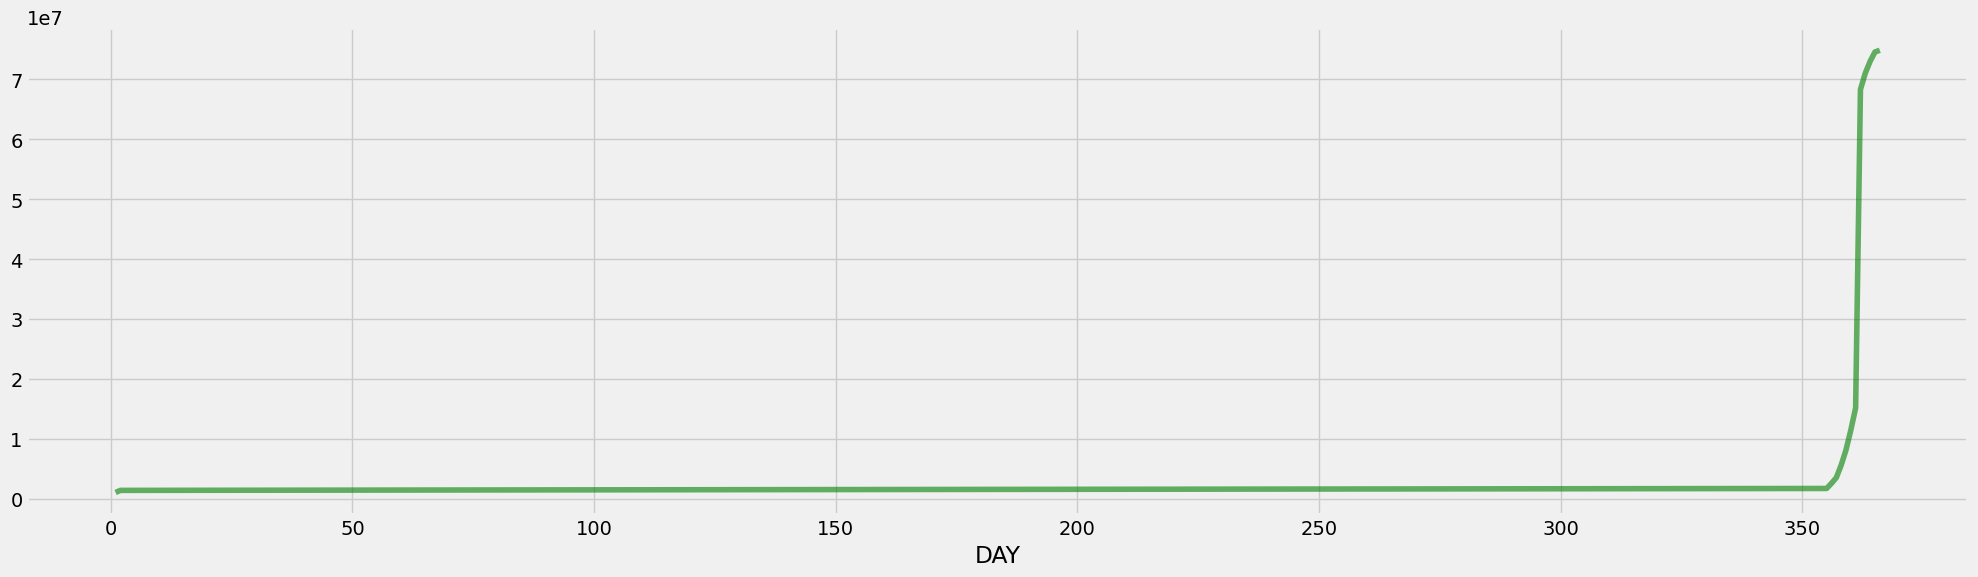

In [8]:
myData.plotExpenses("DAY", "WEEK", 1)